In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [28]:
import os
import os.path
from os import path
import librosa as lb
import pandas as pd
from pathlib import Path
import numpy as np
import IPython.display as ipd
import csv
import scipy
import matplotlib.pyplot as plt

In [4]:
# Set your drive's path for the files used.
maleVoicePath = '/content/drive/My Drive/ML Project/male'
whiteNoisePath = '/content/drive/My Drive/ML Project/whitenoise'
DrivePath = '/content/drive/My Drive/ML Project'
csvPath = '/content/drive/My Drive/ML Project/data.csv'

In [5]:
# Static Variables for audio information
windowLength = 256
overlap      = round(0.25 * windowLength) # overlap of 75%
ffTLength    = windowLength
inputFs      = 48e3
fs           = 16e3
numFeatures  = ffTLength//2 + 1
numSegments  = 8

In [6]:
class FeatureExtractor:
    def __init__(self, audio, *, windowLength, overlap, sample_rate):
        self.audio = audio
        self.ffT_length = windowLength
        self.window_length = windowLength
        self.overlap = overlap
        self.sample_rate = sample_rate
        self.window = scipy.signal.hamming(self.window_length, sym=False)

    def get_stft_spectrogram(self):
        return lb.stft(self.audio, n_fft=self.ffT_length, win_length=self.window_length, hop_length=self.overlap,
                            window=self.window, center=True)

    def get_audio_from_stft_spectrogram(self, stft_features):
        return lb.istft(stft_features, win_length=self.window_length, hop_length=self.overlap,
                             window=self.window, center=True)

    def get_mel_spectrogram(self):
        return lb.feature.melspectrogram(self.audio, sr=self.sample_rate, power=2.0, n_fft=self.ffT_length, hop_length=self.overlap)

    def get_audio_from_mel_spectrogram(self, M):
        return lb.feature.inverse.mel_to_audio(M, sr=self.sample_rate, n_fft=self.ffT_length, hop_length=self.overlap,
                                             win_length=self.window_length, window=self.window,
                                             center=True, pad_mode='reflect', power=2.0, n_iter=32, length=None)

In [7]:
# Source: https://github.com/daitan-innovation/cnn-audio-denoiser/blob/master/SpeechDenoiserCNN.ipynb
def read_audio(filepath, sample_rate, normalize=True):
    """Read an audio file and return it as a numpy array"""
    audio, sr = lb.load(filepath, sr=sample_rate)
    if normalize:
      div_fac = 1 / np.max(np.abs(audio)) / 3.0
      audio = audio * div_fac
    return audio, sr
        
def add_noise_to_clean_audio(clean_audio, noise_signal):
    """Adds noise to an audio sample"""
    if len(clean_audio) >= len(noise_signal):
        # print("The noisy signal is smaller than the clean audio input. Duplicating the noise.")
        while len(clean_audio) >= len(noise_signal):
            noise_signal = np.append(noise_signal, noise_signal)

    ## Extract a noise segment from a random location in the noise file
    ind = np.random.randint(0, noise_signal.size - clean_audio.size)

    noiseSegment = noise_signal[ind: ind + clean_audio.size]

    speech_power = np.sum(clean_audio ** 2)
    noise_power = np.sum(noiseSegment ** 2)
    noisyAudio = clean_audio + np.sqrt(speech_power / noise_power) * noiseSegment
    return noisyAudio

def play(audio, sample_rate):
    ipd.display(ipd.Audio(data=audio, rate=sample_rate))  # load a local WAV file

In [8]:
os.chdir(maleVoicePath) # changes the directory to the one holding the male clips
Mypath = os.getcwd() # gets the directory
Mypath = Mypath + '/' # adds a slash at the end
all_sounds = []
name = []
entries = Path(Mypath) # gets all the files in the directory
for files in entries.iterdir():
  name.append(files.name) # gets the names of each file

'''for index in range(len(os.listdir(path))):
   #Use a smaller list for testing.'''

for index in range(10):
  y, sr = read_audio(Mypath + name[index], fs)
  #lb.load(path + name[index]) # loads each file
  all_sounds.append((y, sr)) # append to list for later use

In [9]:
os.chdir(whiteNoisePath)
Mypath = os.getcwd()
Mypath = Mypath + '/'
entries = Path(Mypath)
name = []
all_whitenoise = []
for files in entries.iterdir():
  name.append(files.name)
for index in range(len(os.listdir(Mypath))):
  y, sr = read_audio(Mypath + name[index], fs)
  all_whitenoise.append((y, sr))

In [ ]:
for sound in all_sounds:
  x, y = sound
  produce_stft_graph(sound)
  play(x, y)

In [ ]:
for sound in all_whitenoise:
  x, y = sound
  play(x, y)
  produce_stft_graph(sound)

In [79]:
# code used from https://librosa.org/doc/latest/generated/librosa.stft.html
#works with both types of sound, either sounds that have been split into their y, sr and those that have not
def produce_stft_graph(sound, sr=1):
  if not isinstance(sound, (np.ndarray)):
    the_sound, sr = sound
  else:
    the_sound = sound
    sr = sr

  soundFeature = FeatureExtractor(the_sound, windowLength=windowLength, overlap=overlap, sample_rate=sr)
  abs_s = np.abs(soundFeature.get_stft_spectrogram())
  fig, ax = plt.subplots()
  img = lb.display.specshow(lb.amplitude_to_db(abs_s, ref=np.max), y_axis='log', x_axis='time', ax=ax)
  ax.set_title('Power spectogram')

test area for making the csv


In [ ]:
soundextractors = []
for sound in all_sounds:
  the_sound, sr = sound
  soundextractors.append(FeatureExtractor(the_sound, windowLength=windowLength, overlap=overlap, sample_rate=sr))

new = False

os.chdir(DrivePath)
if not path.exists('data.csv'):
  new = True

with open("data.csv","w") as file:
  write = csv.writer(file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)

  if new:
    write.writerow(['File', 'stft', 'mel', 'sample rate'])

  for index, sound in enumerate(soundextractors):
    file_path = name[index]
    stft = sound.get_stft_spectrogram()
    mel = sound.get_mel_spectrogram()
    samp_rate = sound.sample_rate

    write.writerow([file_path, stft, mel, samp_rate])

In [ ]:
features = pd.read_csv(csvPath)
features

The code under here is heavily WIP and most doesn't work.

In [ ]:
cleanAudio, sr = all_sounds[1]
print("Min:", np.min(cleanAudio),"Max:",np.max(cleanAudio))
ipd.Audio(data=cleanAudio, rate=sr) # load a local WAV file

In [ ]:
produce_stft_graph(sound = all_sounds[0])

In [ ]:
produce_stft_graph(sound = cleanAudio, sr = sr)

In [ ]:
noiseAudio, sr = all_whitenoise[0]
print("Min:", np.min(noiseAudio),"Max:",np.max(noiseAudio))
ipd.Audio(data=noiseAudio, rate=sr) # load a local WAV file

In [50]:
# Clean Audio Feature Extractor
cleanAudioFeatureExtractor = FeatureExtractor(cleanAudio, windowLength=windowLength, overlap=overlap, sample_rate=sr)
stft_features = cleanAudioFeatureExtractor.get_stft_spectrogram()
stft_features = np.abs(stft_features)
print("Min:", np.min(stft_features),"Max:",np.max(stft_features))

Min: 0.0 Max: 14.039335


clean
dirty
combined


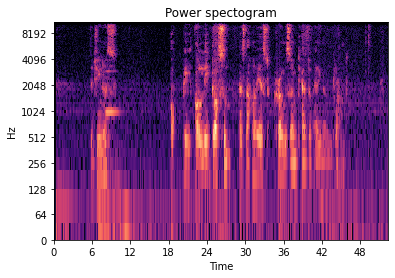

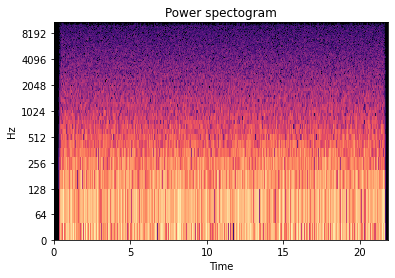

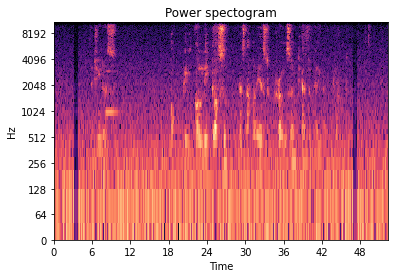

In [83]:
print("clean")
produce_stft_graph(cleanAudio)

print("dirty")
produce_stft_graph(noiseAudio)

noisyAudio = add_noise_to_clean_audio(cleanAudio, noiseAudio)
ipd.Audio(data=noisyAudio, rate=fs) # load a local WAV file

print("combined")
produce_stft_graph(noisyAudio)

In [16]:
def prepare_input_features(stft_features):
    # Phase Aware Scaling: To avoid extreme differences (more than
    # 45 degree) between the noisy and clean phase, the clean spectral magnitude was encoded as similar to [21]:
    noisySTFT = np.concatenate([stft_features[:,0:numSegments-1], stft_features], axis=1)
    stftSegments = np.zeros((numFeatures, numSegments , noisySTFT.shape[1] - numSegments + 1))

    for index in range(noisySTFT.shape[1] - numSegments + 1):
        stftSegments[:,:,index] = noisySTFT[:,index:index + numSegments]
    return stftSegments

In [17]:
noiseAudioFeatureExtractor = FeatureExtractor(noisyAudio, windowLength=windowLength, overlap=overlap, sample_rate=sr)
noise_stft_features = noiseAudioFeatureExtractor.get_stft_spectrogram()

# Paper: Besides, spectral phase was not used in the training phase.
# At reconstruction, noisy spectral phase was used instead to
# perform in- verse STFT and recover human speech.
noisyPhase = np.angle(noise_stft_features)
print(noisyPhase.shape)
noise_stft_features = np.abs(noise_stft_features)

mean = np.mean(noise_stft_features)
std = np.std(noise_stft_features)
noise_stft_features = (noise_stft_features - mean) / std

(129, 2257)
